In [1]:
%matplotlib inline

In [2]:
import numpy as np

In [3]:
#parameters
M = 10  # number of realisations
N = int(100e6 // 8)  # number of steps

In [4]:
def walk(steps):
    x = np.zeros_like(steps)
    for l in range(steps.shape[-1]):
        x[..., l] = x[..., l-1] + steps[..., l]
    return x

In [5]:
steps = np.random.normal(size=(M, N))
steps.shape

(10, 12500000)

In [6]:
%time walk(steps).std()

CPU times: user 22.2 s, sys: 494 ms, total: 22.7 s
Wall time: 22.7 s


2459.1989951024307

In [7]:
from numba import jit

In [8]:
@jit
def walk_jit(steps):
    x = np.zeros_like(steps)
    for l in range(steps.shape[-1]):
        x[..., l] = x[..., l-1] + steps[..., l]
    return x

In [9]:
%time walk_jit(steps).std()

CPU times: user 2.69 s, sys: 396 ms, total: 3.09 s
Wall time: 3.1 s


2459.1989951024307

In [10]:
from dask import array as da
from dask.distributed import Client, wait
import os

In [11]:
client = Client(n_workers=5, threads_per_worker=1, memory_limit=2e9, ip=os.environ["HOSTNAME"])
client

Client Scheduler: tcp://10.8.0.42:43460 Dashboard: http://10.8.0.42:8787/status,Cluster Workers: 5 Cores: 5 Memory: 10.00 GB


In [12]:
steps = da.random.normal(size=(M, N), chunks=(1, N))
steps

dask.array<normal, shape=(10, 12500000), dtype=float64, chunksize=(1, 12500000)>

In [13]:
%time da.apply_along_axis(walk, -1, steps).std().compute()

CPU times: user 2.17 s, sys: 354 ms, total: 2.52 s
Wall time: 33.9 s


2065.186766687778

In [14]:
%time da.apply_along_axis(walk_jit, -1, steps).std().compute()

CPU times: user 349 ms, sys: 35 ms, total: 384 ms
Wall time: 2.74 s


2065.186766687778

In [15]:
steps = da.random.normal(size=(3 * M, N), chunks=(3, N))
steps

dask.array<normal, shape=(30, 12500000), dtype=float64, chunksize=(3, 12500000)>

In [16]:
%time da.apply_along_axis(walk_jit, -1, steps).std().compute()

CPU times: user 853 ms, sys: 94.8 ms, total: 948 ms
Wall time: 5.12 s


2401.805403830685

In [17]:
from dask_jobqueue import SLURMCluster

/p/project/cecam/rath1/miniconda3_20190521/envs/dask_jobqueue_workshop/lib/python3.7/site-packages/docrep/__init__.py:341: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  s = dedents('\n' + '\n'.join(lines[first:]))


In [18]:
cluster = SLURMCluster(
    cores=24,
    processes=12,
    memory="100GB",
    shebang='#!/usr/bin/env bash',
    queue="batch",
    walltime="00:30:00",
    local_directory='/tmp',
    death_timeout="15s",
    interface="ib0",
    log_directory="$SCRATCH_cecam/$USER/dask_jobqueue_logs/",
    project="ecam")

/p/project/cecam/rath1/miniconda3_20190521/envs/dask_jobqueue_workshop/lib/python3.7/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [19]:
client = Client(cluster)

In [20]:
client

Client Scheduler: tcp://10.80.32.42:42499 Dashboard: http://10.80.32.42:38739/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


In [21]:
cluster.scale(48)

In [22]:
steps = da.random.normal(size=(100 * M, N), chunks=(1, N))
steps

dask.array<normal, shape=(1000, 12500000), dtype=float64, chunksize=(1, 12500000)>

In [23]:
client

Client Scheduler: tcp://10.80.32.42:42499 Dashboard: http://10.80.32.42:38739/status,Cluster Workers: 48 Cores: 96 Memory: 399.84 GB


In [24]:
%time da.apply_along_axis(walk_jit, -1, steps).std().compute()

CPU times: user 9.2 s, sys: 1.02 s, total: 10.2 s
Wall time: 14.8 s


2535.4841605505894

In [25]:
steps.nbytes / 1e9

100.0

In [26]:
%time last_pos = da.apply_along_axis(walk_jit, -1, steps)[:, -1].compute()

CPU times: user 8.19 s, sys: 948 ms, total: 9.14 s
Wall time: 12.3 s


In [30]:
from matplotlib import pyplot as plt

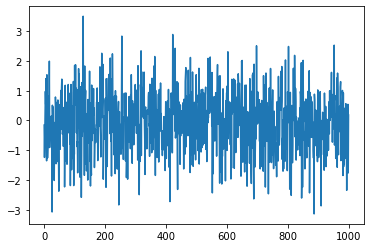

In [33]:
plt.plot(last_pos, rasterized=True);

In [39]:
steps = da.random.normal(size=(100 * M, 2 * N), chunks=(1, N))
steps

dask.array<normal, shape=(1000, 25000000), dtype=float64, chunksize=(1, 12500000)>

In [40]:
%time last_pos = da.apply_along_axis(walk_jit, -1, steps)[:, -1].compute()

CPU times: user 15.3 s, sys: 1.81 s, total: 17.1 s
Wall time: 22.4 s


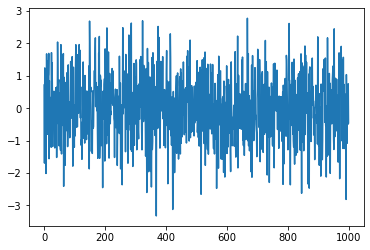

In [41]:
plt.plot(last_pos, rasterized=True);

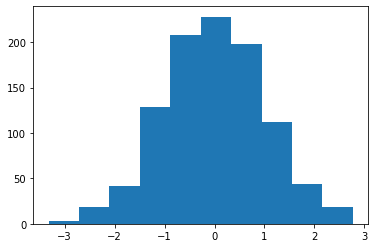

In [42]:
plt.hist(last_pos, rasterized=True);